In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time 
import os
import copy

plt.ion()

In [2]:
# load data with torchvision and torch.utils.data packages
# data auguentation and normalization for training
# just normalization for validation
data_transforms = {
    'train': transforms.Compose([
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], 
                              [0.229, 0.224, 0.225])
    ]), 
    # We choose these numbers to normalise the image to [0,1].
    # Use next function to find minimum and maximum of each 
    # dimension with np.min(inp, axis = 0). Then set the mean
    # and std of each dimension based on these numbers.
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=4,
                                              shuffle=True, 
                                              num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

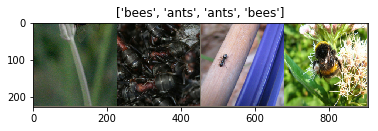

In [38]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    # save model
    best_model_wts = copy.deepcopy(model.state_dict)
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)
        
        # each epoch has training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step() 
                # an LR scheduler object from torch.optim.lr_scheduler
                model.train() 
                # use this to tell the model it is training
            else:
                model.eval()
                # use this to tell the model it is NOT training
                # and stop batch normalisation etc.
                
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history only if train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
            
            

In [49]:
# Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    # model.eval() will notify all your layers that you are 
    # in eval mode, that way, batchnorm or dropout layers
    # will work in eval model instead of training mode.
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        # torch.no_grad() impacts the autograd engine and 
        # deactivate it. It will reduce memory usage and 
        # speed up computations but you won’t be able to 
        # backprop (which you don’t want in an eval script).
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        # go back to the training/not training mode the model was in before

In [30]:
# Finetuning the convnet:
# Load a pretrained model and reset final fully connected layer.
model_ft = models.resnet18(pretrained=True)

# ConvNet as fixed feature extractor: uncomment the following code
# Here, we need to freeze all the network except the final layer. 
# We need to set requires_grad == False to freeze the parameters 
# so that the gradients are not computed in backward(). 

for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe all parameters are being optimised
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, 
                                       step_size=7,
                                       gamma=0.1)

In [32]:
# train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/4
----------
train Loss: 0.2423 Acc: 0.9016
val Loss: 0.1815 Acc: 0.9542

Epoch 1/4
----------
train Loss: 0.3586 Acc: 0.8607
val Loss: 0.1741 Acc: 0.9542

Epoch 2/4
----------
train Loss: 0.3639 Acc: 0.8443
val Loss: 0.1770 Acc: 0.9542

Epoch 3/4
----------
train Loss: 0.3008 Acc: 0.8443
val Loss: 0.1678 Acc: 0.9542

Epoch 4/4
----------
train Loss: 0.2879 Acc: 0.8730
val Loss: 0.1794 Acc: 0.9412

Training complete in 1m 5s
Best val Acc: 0.954248


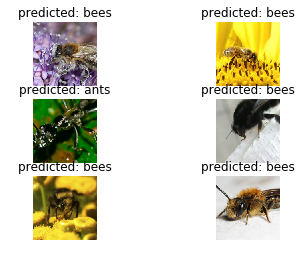

In [50]:
visualize_model(model_ft)
plt.ioff()
plt.show()